In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../src/")

In [1716]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import xrscipy.signal as dsp
from xarrayutils.vertical_coordinates import linear_interpolation_regrid, linear_interpolation_remap
import gsw

from niwtools.tools import *
from niwtools.qc import qc_turbulence, qc_velocity

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d %b')

import warnings
warnings.simplefilter("ignore")

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [5]:
# events = {'A':{'floatids':['7779a','7781a','7783a','7786a','7787a','7788a'],'times':['2016-08-28','2016-09-04']},
#          'C': {'floatids':['7781a','7786a','7788a'],'times':['2016-10-02','2016-10-11']},
#          'D': {'floatids':['7779a','7781a','7786a','7788a'],'times':['2016-10-17','2016-11-03']},
#          'E': {'floatids':['7779a','7787a'],'times':['2016-10-27','2016-11-05']}
#          }

# with open('events.yml','w') as fp:
#     yaml.dump(events,fp)

In [1571]:
def compute_shear(raw):
    raw['dudz'] = raw.u.differentiate('z',)
    raw['dvdz'] = raw.v.differentiate('z')
    raw['S'] = 0.5*(raw.dudz**2 + raw.dvdz**2)

    raw['dudzNI'] = raw.uNI.differentiate('z')
    raw['dvdzNI'] = raw.vNI.differentiate('z')
    raw['SNI'] = 0.5*(raw.dudzNI**2 + raw.dvdzNI**2)
    return raw

def get_new_coodinates(data, variable, new_min, new_max):
    ''' regrid data onto sigma
    '''
    if data.z.min()<0:
        data.coords['z'] = -data.z
    new_vals = np.arange(new_min,new_max, 0.01)
    new_values = xr.DataArray(new_vals, coords=[('sigma', new_vals)]) # define the new temperature grid

    return linear_interpolation_regrid(data.z, data[variable], new_values, target_value_dim='sigma')

def remap_variable(data,variable,new_coords):
    if data.z.min()<0:
        data.coords['z'] = -data.z
    _,data['zmap'] = xr.broadcast(data[variable],data.z)
    return linear_interpolation_remap(data.z, data.zmap, new_coords)

def compute_iso_disp(raw):
    f = gsw.f(40.7)/(2*np.pi)
    raw = lowpass_variable(raw,'rho0', 0.6*f, 1.25*f)
    raw['rho_ref'] = raw.rho0LOW

    raw['sigma'] = raw.rho0 -1000
    raw['sigma_ref'] = raw.rho_ref -1000

    raw['sigma'] = xr.where(raw['sigma']<20, np.nan, raw['sigma'])
    raw['sigma_ref'] = xr.where(raw['sigma_ref']<20, np.nan, raw['sigma_ref'])
    new_min = raw.sigma.min()
    new_max = raw.sigma.max()
    #return raw

    sigma_coords = get_new_coodinates(raw,'sigma', new_min, new_max)
    sigma_ref_coords = get_new_coodinates(raw,'sigma_ref', new_min, new_max)

    ds_z = remap_variable(raw,'sigma',sigma_coords).rename({'remapped':'sigma'})
    ds_z_ref = remap_variable(raw,'sigma_ref',sigma_ref_coords).rename({'remapped':'sigma'})
    eta_sigma = (ds_z_ref-ds_z).transpose() # this is in sigma space
    
    z_values = xr.DataArray(raw.z.values, coords=[('z', raw.z.values)]) # define the new z grid
    z_coord = linear_interpolation_regrid(ds_z.sigma, ds_z.transpose(), z_values, target_value_dim='z')
    eta = linear_interpolation_remap(eta_sigma.sigma, eta_sigma, z_coord).transpose()
    raw['eta'] = eta.rename({'remapped':'z'}) #.transpose()
    
    if raw.z.max()>0:
        raw.coords['z'] = -raw.z
    return raw

def compute_tendency(raw):
    raw['dape'] = (raw.eta_ape.resample(time='1h')
        .interpolate('linear').rolling(time=18, center=True)
        .mean()
        .differentiate('time',datetime_unit='s')).interp_like(raw.eta_ape)
    raw['dhke'] = (raw.hkeNI.resample(time='1h')
        .interpolate('linear').rolling(time=18, center=True)
        .mean()
        .differentiate('time',datetime_unit='s')).interp_like(raw.hkeNI)
    return raw

def phase_cos(t, a, b, c):
    fi = gsw.f(40.7)
    return a*np.cos(fi*t + b) + c

def xr_cosine_fit(tt,yy):
    
    def cosine_fit(tt,yy): 
        # those are the window time vectors
        yy = yy[~np.isnan(yy)]
        if len(yy)>4:
            try:
                tt = tt[~np.isnan(yy)] 
                popt, _ = curve_fit(phase_cos, tt, yy) # fit over window
            except:
                popt = np.array([np.nan,np.nan,np.nan])
        else:
            popt = np.array([np.nan,np.nan,np.nan])
        return popt

    return xr.apply_ufunc(cosine_fit, tt, yy,
                          input_core_dims=[['new'],['new']],
                          output_core_dims=[['popt']],
                          vectorize=True, 
                          output_dtypes=['float64'], 
                          output_sizes={'popt': 3})

def fit_cosine_to_eta(raw):
    raw['ddtime'] = raw.dtime
    test = raw[['ddtime','eta']].dropna('time', how='all').dropna('z', how='all')
#     test = test.resample(time='2h').interpolate('linear')
    test = test.swap_dims({'time':'dtime'})
    a = test.rolling(dtime=18, center=True).construct('new')
    results = xr_cosine_fit(a.ddtime, a.eta)
    test['amp'] = results.isel(popt=0,drop=True)
    test['phase'] = results.isel(popt=1,drop=True)
    test['resid'] = results.isel(popt=2,drop=True)
    test['fit'] = phase_cos(test.dtime, test.amp, test.phase, test.resid)
#     raw['eta_fit'] = phase_cos(test.ddtime, test.amp, test.phase, test.resid)
    return test

def integral_1d2(zz,yy):
#     print(data.dims)
    result = []
    zlist = []

    for zi,z in enumerate(zz[:-100]):
        ztest = zz[zi:]
        ytest= yy[zi:]
#         print( ztest[~np.isnan(ytest)].size)
        res = trapz(ztest[~np.isnan(ytest)],ytest[~np.isnan(ytest)])
        if res.size >0 :
            result.append( res )
            zlist.append(z)
        else:
            result.append( np.nan )
            zlist.append(np.nan)
#     print(len(zlist))
#     print(len(result))
    return np.array(result), -np.array(zlist) 

def wrap_integral(zz,yy):
    return xr.apply_ufunc(integral_1d2,zz,yy,
                          input_core_dims=[['z'],['z']],
                          output_core_dims=[['newz'],['newz']],
                          vectorize=True) 

def find_pprime(raw):
    raw['bprime_fit'] = -raw.n2*raw.eta_fit
    raw['bprime_fit_anom'] = raw.bprime_fit - raw.bprime_fit.mean('time') - raw.bprime_fit.mean('z')
    
    testwrap, testwrapz = wrap_integral(raw.bprime_fit_anom.z,raw.bprime_fit_anom)
    testwrap['newz'] = ('newz', -testwrapz.mean('time'))
    raw['pprime'] = testwrap.interp(newz=raw.z).transpose()
    
    raw['pprime'] = raw.pprime - raw.pprime.mean('z') - raw.pprime.mean('time')
    return raw

def compute_efluxes(raw):
    raw['up'] = (raw.uNI-raw.uNI.mean('time')-raw.uNI.mean('z'))*raw.pprime
    raw['vp'] = (raw.vNI-raw.vNI.mean('time')-raw.vNI.mean('z'))*raw.pprime
    raw['wp'] = (raw.w_fit*raw.pprime)
    return raw

def backrotate_phase(ang):
    ref_time = pd.to_datetime('28/12/1988')
    timestamp = pd.to_datetime(ang.time.values)
    Tf =2 * np.pi / gsw.f(40.7)
    dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s') % Tf
    phase_add = (dt.values * gsw.f(40.7)).astype('float')
    ang_br = ang + phase_add*180/np.pi    
    return wrap(ang_br)

def backrotate_rc(phase0):
    f= gsw.f(40.7)
    ref_time = pd.to_datetime('28/12/1988')
    timestamp = pd.to_datetime(phase0.time.values)
    dt = (timestamp - ref_time) / pd.to_timedelta(1, unit='s')
    backrotate = np.arctan2(np.sin(f*dt.values),np.cos(f*dt.values))*180/np.pi
  
    return wrap(phase0 + backrotate)

def wrap(test, deg=True):
    if deg:
        phases = (( -test + 180) % (2.0 * 180 ) - 180) * -1.0
    else:
        phases = (( -test + np.pi) % (2.0 * np.pi ) - np.pi) * -1.0
    return phases

def compute_phase(raw):
    raw['ang'] =  ( ('z','time'),  np.angle(raw.uNI + 1j*raw.vNI, deg=True))
    raw['angS'] =  ( ('z','time'), np.angle(raw.dudzNI + 1j*raw.dvdzNI, deg=True) )
    raw['angS_br0'] = backrotate_phase(raw.angS)
    raw['ang_br0'] = backrotate_phase(raw.ang)
    raw['rcs_phase'] = backrotate_rc(raw.ang)
    return raw

def rotate_ds(raw):
    """
    Rotate to move from magnetic coordinate system to cartesian coordinate system
    magvar is in *-vel.mat float files.
    """
    def rotate(ds):
        """Simple 2d rotation"""
        ds['uo'] = ds.u # save old velocity for comparison
        ds['vo'] = ds.v
        ds['u'] = ('z', ds.u*np.cos(ds.magvar) - ds.v*np.sin(ds.magvar))
        ds['v'] = ('z', ds.u*np.sin(ds.magvar) + ds.v*np.cos(ds.magvar))
        return ds
    
    catch=[]
    for t in range( raw.time.size ):
        ds = raw.isel(time=t)
        catch.append(rotate(ds))
    return xr.concat(catch, dim='time').transpose()

def polar(raw):
    """
    Change velocity and fluxes to polar/eddy coordinate system.
    """
    radius = []
    theta = []
    u_r = []
    u_theta = []
    for t in range(raw.time.size):
        test = raw.isel(time=t)
        radius.append( gsw.distance([test.lon,raw.lon.median()],[test.lat,raw.lat.median()]) )

        theta_temp = np.arctan2( test.lat - raw.lat.median(), test.lon - raw.lon.median() )
        theta.append( theta_temp )
    raw['theta'] = xr.concat( theta , dim='time' )
    raw['radius'] = (('time'), np.array( radius ).flatten() )
    
    # compute radial and azimuthal velocity
    raw['u_r'] = raw.uNI*np.cos(raw.theta) + raw.vNI*np.sin(raw.theta)
    raw['u_theta'] = -raw.uNI*np.sin(raw.theta) + raw.vNI*np.cos(raw.theta)
    
    # compute fluxes
    raw['ur_p'] = (raw.u_r-raw.u_r.mean('time')-raw.u_r.mean('z'))*raw.pprime
    raw['utheta_p'] = (raw.u_theta-raw.u_theta.mean('time')-raw.u_theta.mean('z'))*raw.pprime
    
    return raw 

In [1706]:
with open('events.yml') as fp:
    events = yaml.full_load(fp)
    
event='A'
floatid = '7787a'

collecter=[]
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
# QC velocity and turbulence
raw = qc_velocity(raw, RotPmax = 20, verrmax = 0.1)
rawall = raw.copy()

# magnetic declination
magvar = xr.load_dataset(f'./magvar_{floatid}.nc')
raw['magvar'] = ('time', magvar.magvar.interp(time=raw.time).pipe(np.deg2rad))
raw = rotate_ds(raw)
raw = qc_turbulence(raw)

# raw = raw.sel(time=slice('2016-08-27T15:00', '2016-09-03T06:00'))
raw = raw.sel(time=slice(*events[event]['times']))

f = gsw.f(40.7)/(2*np.pi)
# bandpass filtering
raw = bandpass_velocity(raw, 0.7*f, 1.3*f)
raw = add_cfs_data(raw, floatid, 0.7*f, 1.3*f)
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
# mask = ~np.isnan(raw.u) & ~np.isnan(raw.v)
rho0=raw.rho0.mean()
raw['hkeNI'] = 0.5*( raw.uNI**2 + raw.vNI**2) # m2/s2
raw['hkeTOT'] = 0.5*( raw.u**2 + raw.v**2)
raw['floatid'] = floatid
raw['n2'] = -9.81*raw.rho0.differentiate('z')/1025

raw = compute_shear(raw)
# isopycnal displacements
raw = compute_iso_disp(raw)
# HKE and APE
raw['eta_ape'] = raw.eta**2*raw.n2/2  #m2/s2
raw['hke_ape'] = raw.hkeNI/raw.eta_ape
# Power
raw = compute_tendency(raw)
# fit eta and compute w
new = fit_cosine_to_eta(raw) # only for debugging
raw['eta_fit'] = new.swap_dims({'dtime':'time'}).fit.transpose()
raw['w_fit'] = raw.eta_fit.differentiate('time',datetime_unit='s')

# raw['bprime_fit'] = -raw.n2*raw.eta_fit
# raw['bprime_fit_anom'] = raw.bprime_fit - raw.bprime_fit.mean('time') - raw.bprime_fit.mean('z')
raw = find_pprime(raw)
raw = compute_efluxes(raw)
raw = compute_phase(raw)
raw = polar(raw)
# collecter.append(raw)†
    
# ds = xr.concat(collecter,dim='floatid')

In [1707]:
h = raw.n2.plot();
plt.close()

Text(0.9, -0.2, '2016')

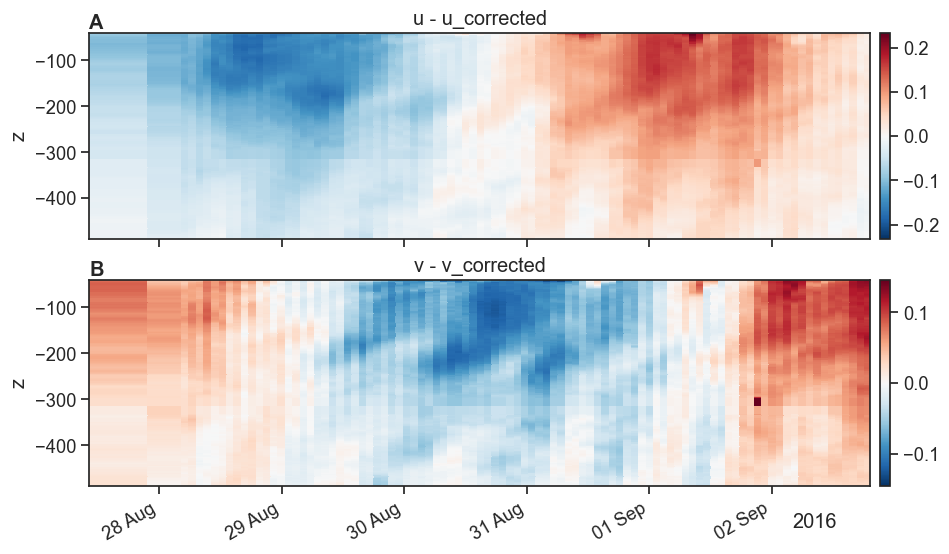

In [1708]:
fig,ax = plt.subplots(2,1, sharex=True)
(raw.vo-raw.v).dropna('z').plot(ax=ax[0], cbar_kwargs={'pad':0.01})
ax[0].set_title('u - u_corrected')
(raw.uo-raw.u).dropna('z').plot(ax=ax[1], cbar_kwargs={'pad':0.01})
ax[1].set_title('v - v_corrected')

alphabet(ax)
for ax in ax:
    ax.set_xlabel(None)
    ax.xaxis.set_major_formatter(myFmt)
ax.annotate('2016',(0.9,-0.2),xycoords='axes fraction')

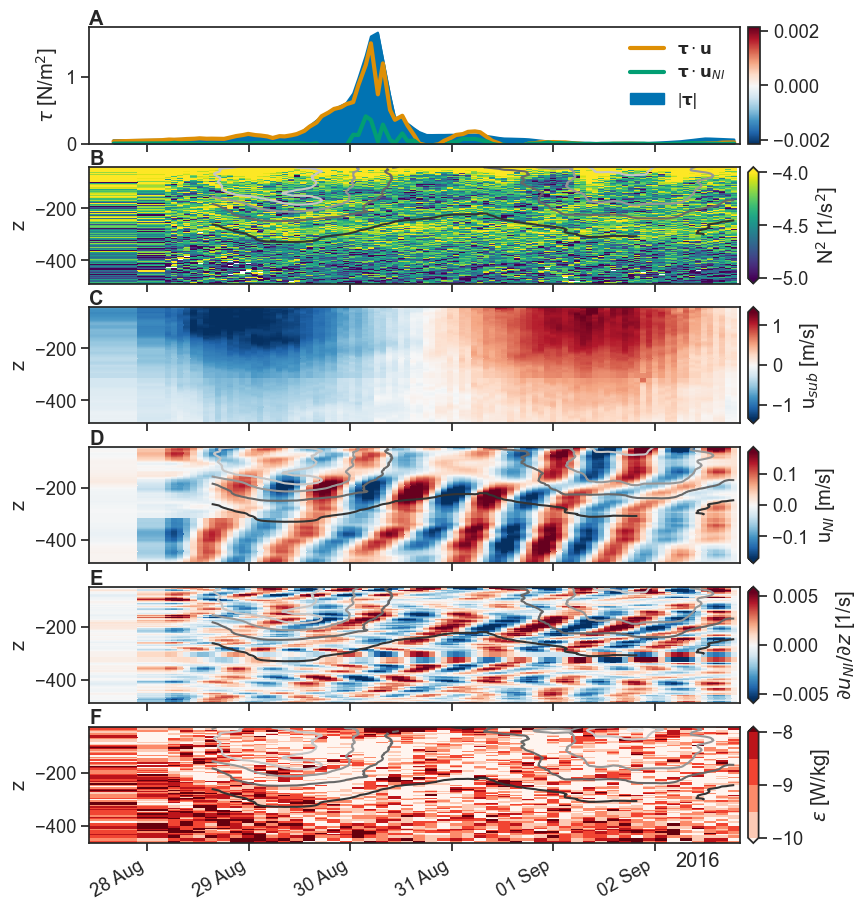

In [1709]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.2)
fig, ax = plt.subplots(6,1, sharex=True, figsize=(10,12))

# tau
# raw.tau.dropna('time',how='all').dropna('z').plot(ax=ax[0])
raw.tau.to_series().plot.area(label=r'|$\mathbf{\tau}|$', ax=ax[0])
raw.taudotu.plot(lw=3,label=r'$\mathbf{\tau} \cdot \mathbf{u}$', ax=ax[0])
raw.taudotu_ni.plot(lw=3,label=r'$\mathbf{\tau} \cdot \mathbf{u}_{NI}$', ax=ax[0])

plt.colorbar(h, ax=ax[0], pad=0.01, aspect=10)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r'$\tau$ [N/m$^2$]')

# n2
raw.n2.dropna('time',how='all').dropna('z').pipe(np.log10).plot(
    ax=ax[1], cmap='viridis', cbar_kwargs={'pad':0.01,'aspect':10,'label': r'N$^2$ [1/s$^2$]'},rasterized=True,
    vmin=-5,vmax=-4)
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).rolling(time=10).mean().plot.contour(ax=ax[1], cmap='Greys_r')

# subinerital u
(raw.u-raw.uNI).dropna('time',how='all').dropna('z').plot(
    ax=ax[2], cbar_kwargs={'pad':0.01,'aspect':10, 'label': r'u$_{sub}$ [m/s]'},rasterized=True, robust=True)

# inertial u
raw.uNI.dropna('time',how='all').dropna('z').plot(
    ax=ax[3], cbar_kwargs={'pad':0.01,'aspect':10, 'label': r'u$_{NI}$ [m/s]'},rasterized=True, robust=True)
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).rolling(time=10).mean().plot.contour(ax=ax[3], cmap='Greys_r')

# uz
raw.dudzNI.dropna('time',how='all').dropna('z').plot(
    ax=ax[4], cbar_kwargs={'pad':0.01,'aspect':10, 'label': r'$\partial u_{NI}/ \partial z$ [1/s]'},rasterized=True, robust=True)
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).rolling(time=10).mean().plot.contour(ax=ax[4], cmap='Greys_r')

# epsilon
raw.eps.dropna('time',how='all').dropna('z').pipe(np.log10).plot(
    ax=ax[5], cmap='Reds',vmin=-10, vmax=-8,levels=5,
    cbar_kwargs={'pad':0.01,'aspect':10,'ticks':[-8,-9,-10,-11], 'label': r'$\varepsilon$ [W/kg]'})
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).rolling(time=10).mean().plot.contour(ax=ax[5], cmap='Greys_r')

alphabet(ax)
for ax in ax:
    ax.set_xlabel(None)
    ax.xaxis.set_major_formatter(myFmt)
ax.annotate('2016',(0.9,-0.2),xycoords='axes fraction')

# fig.subplots_adjust(hspace=0.1)
plt.savefig(f'../figures/polar_fluxes/{floatid}_niw_figure.pdf')

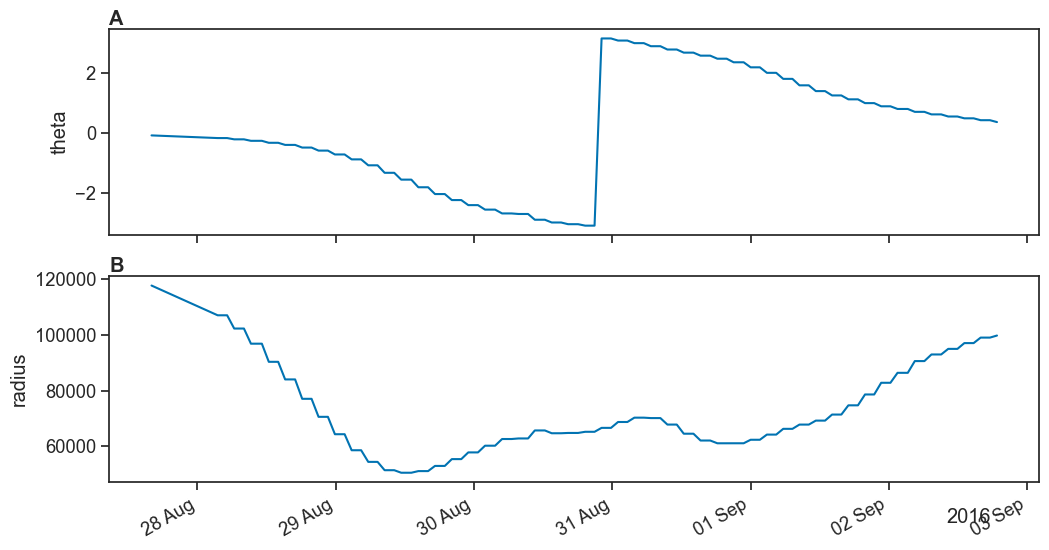

In [1710]:
fig, ax = plt.subplots(2,1, sharex=True)
raw.theta.plot(ax=ax[0])
raw.radius.plot(ax=ax[1])

alphabet(ax)
for ax in ax:
    ax.set_xlabel(None)
    ax.xaxis.set_major_formatter(myFmt)
ax.annotate('2016',(0.9,-0.2),xycoords='axes fraction')

plt.savefig(f'../figures/polar_fluxes/{floatid}_theta_radius.pdf')

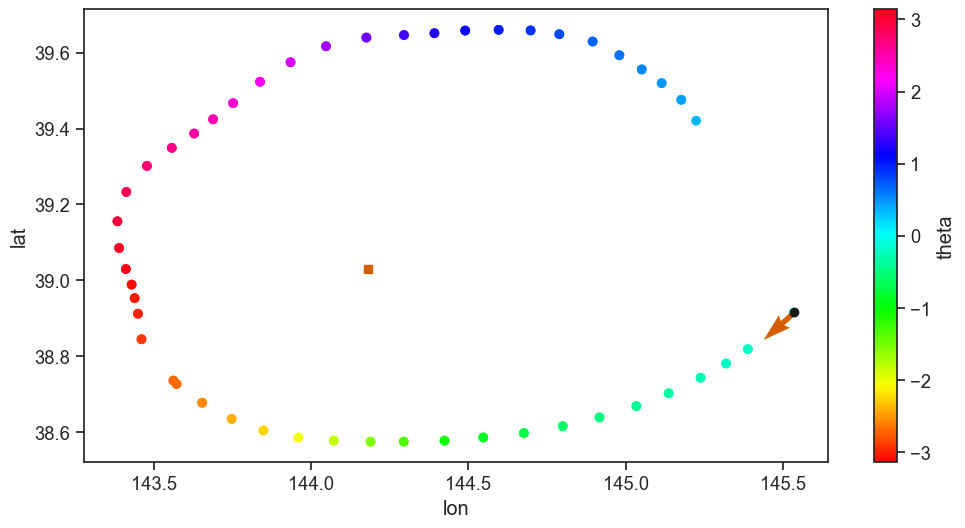

In [1711]:
test = raw.isel(time=0)
raw.plot.scatter('lon', 'lat', hue='theta', cmap='hsv')
plt.plot(raw.lon.median(),raw.lat.median(), 's',color='r')
plt.plot(test.lon.mean(),test.lat.median(), 'o',color='k')
plt.quiver(test.lon.mean (),test.lat.median(),test.u.isel(z=50),test.v.isel(z=50), color='r')

plt.savefig(f'../figures/polar_fluxes/{floatid}_theta_map.pdf')

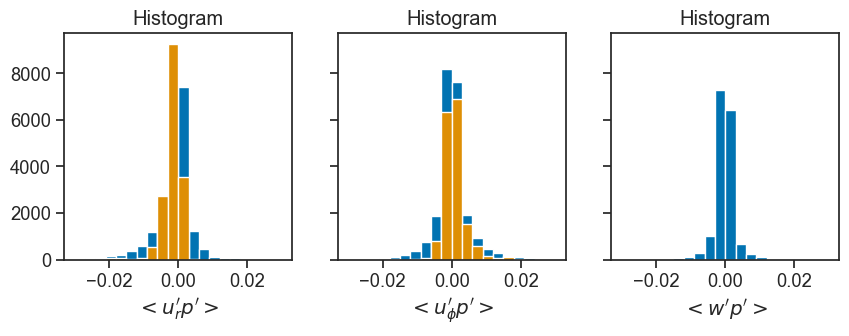

In [1712]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,3))

ranges= (-0.03,0.03)
raw.ur_p.plot.hist(bins=20, ax=ax[0], range=ranges)
raw.ur_p.dropna('z').rolling(time=18).mean().plot.hist(bins=20, ax=ax[0], range=ranges);
ax[0].set_xlabel(r"$<u_r'p'>$")

raw.utheta_p.plot.hist(bins=20, ax=ax[1], range=ranges)
raw.utheta_p.dropna('z').rolling(time=18).mean().plot.hist(bins=20, ax=ax[1], range=ranges);
ax[1].set_xlabel(r"$<u_{\phi}'p'>$")

raw.wp.pipe(lambda x: x*1e2).plot.hist(bins=20, ax=ax[2], range=ranges)
raw.wp.dropna('time',how='all').rolling(time=18).mean().dropna('z').pipe(lambda x: x*1e2).plot.hist(bins=20, ax=ax[2], range=ranges);
ax[2].set_xlabel(r"$<w'p'>$")

plt.savefig(f'../figures/polar_fluxes/{floatid}_eflux_histo.pdf')

In [1713]:
raw['ur_p_filt'] = raw.ur_p.dropna('z').rolling(time=10).mean()
raw['utheta_p_filt'] = raw.utheta_p.dropna('z').rolling(time=10).mean()
raw['wp_filt'] = raw.wp.dropna('time',how='all').rolling(time=10).mean()

In [1714]:
mask =  (raw.z<-170) & (raw.z<-400)
# mask =  (raw.z>-40)

In [1715]:
import matplotlib.patches as patches

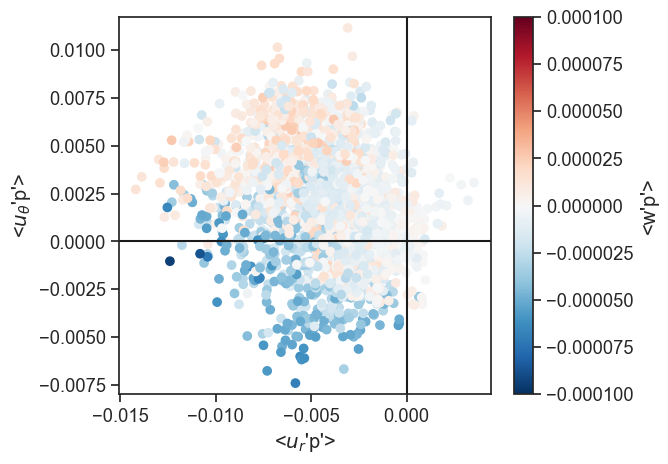

In [1694]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

# raw.where(mask).plot.scatter('ur_p_filt','utheta_p_filt', ax=ax[0])
# ax[0].axhline(0,color='k')
# ax[0].axvline(0,color='k')

# raw.where(mask).plot.scatter('ur_p','utheta_p', ax=ax,hue='wp', vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
(raw.where(mask).plot.scatter('ur_p_filt','utheta_p_filt', ax=ax,hue='wp_filt', 
                             vmin=-1e-4, vmax=1e-4, cmap='RdBu_r', cbar_kwargs={'label':r"<w'p'>"}))
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.axis('equal')

ax.set_xlabel(r"<$u_r$'p'>")
ax.set_ylabel(r"<$u_\theta$'p'>")

# raw.plot.scatter('ur_p','wp', ax=ax[1])
# raw.plot.scatter('up','wp', ax=ax[2]);
# raw.plot.scatter('vp','wp', ax=ax[2]);
# raw.plot.scatter('up','vp', ax=ax[2]);;

plt.savefig('../figures/polar_fluxes/utheta_vs_ur_with_wp.pdf')

In [1695]:
raw['kz_vel'] = raw.ang_br0.pipe(np.radians).differentiate('z').pipe(lambda x: x/(2*np.pi))
raw['kz_vel1'] = (raw.ang_br0.pipe(np.radians).pipe(np.cos).differentiate('z')/ raw.ang_br0.pipe(np.radians).pipe(np.sin)).pipe(lambda x: -x/(2*np.pi))

raw['kz_shear'] = raw.angS_br0.pipe(np.radians).differentiate('z').pipe(lambda x: x/(2*np.pi))
raw['kz_shear1'] = (raw.angS_br0.pipe(np.radians).pipe(np.cos).differentiate('z')/ raw.angS_br0.pipe(np.radians).pipe(np.sin)).pipe(lambda x: -x/(2*np.pi))

raw['hke_kz'] = raw.kz_vel1*raw.hkeNI/raw.hkeNI.mean('time')
raw['hke_shear_kz'] = raw.kz_shear1*raw.S2.rolling(time=9).mean()/raw.S2.mean('time')

In [1696]:
raw['logkz'] = np.log10( raw.kz_vel1 )
raw['Ri'] = raw.n2/raw.S2
raw['logn2'] = raw.n2.pipe(np.log10)

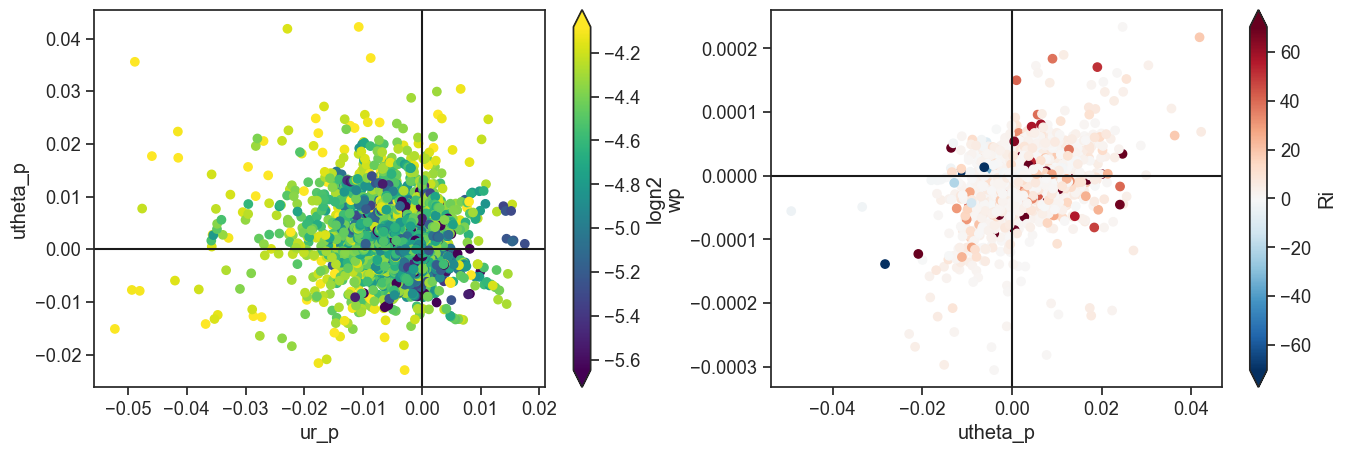

In [1697]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

raw.where(mask).plot.scatter('ur_p','utheta_p', ax=ax[0], hue='logn2',robust=True)
ax[0].axhline(0,color='k')
ax[0].axvline(0,color='k')

raw.where(mask).plot.scatter('utheta_p','wp', ax=ax[1], hue='Ri',robust=True)
ax[1].axhline(0,color='k')
ax[1].axvline(0,color='k')

In [1698]:
raw = raw.set_coords( ['theta','radius'])

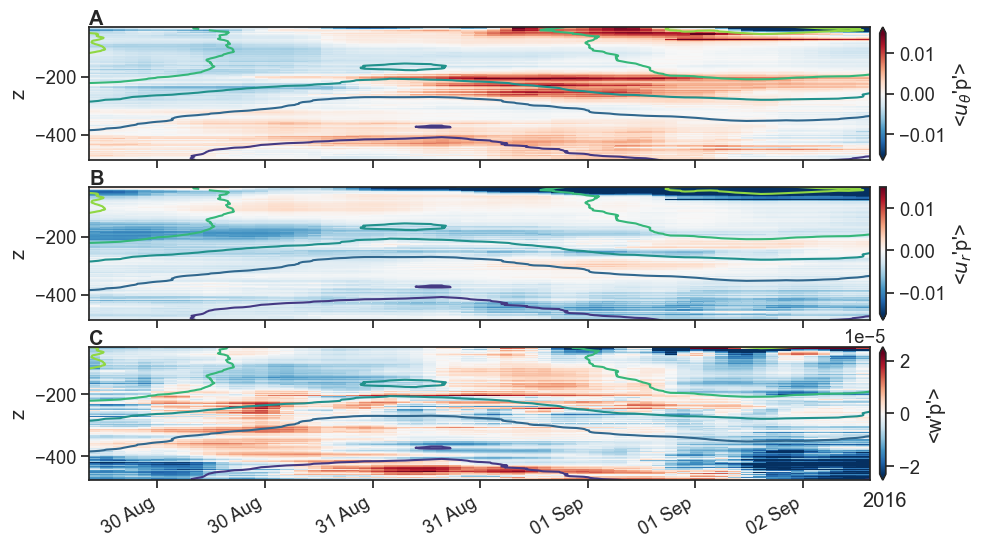

In [1699]:
fig, ax =plt.subplots(3,1, sharex=True)
raw.utheta_p.rolling(time=18).mean().dropna('time',how='all').dropna('z').plot(
    ax=ax[0], vmin=-0.015,vmax=0.015,cmap='RdBu_r', cbar_kwargs={'label':r"<$u_\theta$'p'>",'pad':0.01})
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).pipe(np.sqrt).rolling(time=18).mean().plot.contour(ax=ax[0])
ax[0].set_xlabel(None)
raw.ur_p.rolling(time=18).mean().dropna('time',how='all').dropna('z').plot(
    robust=True, ax=ax[1], vmin=-0.015,vmax=0.015,cmap='RdBu_r' , cbar_kwargs={'label':r"<$u_r$'p'>",'pad':0.01})
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).pipe(np.sqrt).rolling(time=18).mean().plot.contour(ax=ax[1])
# ax[1].set_xlabel('Theta [rad]')
ax[1].set_xlabel(None)

raw.wp.rolling(time=18).mean().dropna('time',how='all').dropna('z').plot(
    robust=True, ax=ax[2],cmap='RdBu_r', cbar_kwargs={'label':r"<w'p'>",'pad':0.01})
((raw.u-raw.uNI)**2 + (raw.v-raw.vNI)**2).pipe(np.sqrt).rolling(time=18).mean().plot.contour(ax=ax[2])
# ax[1].set_xlabel('Theta [rad]')
ax[2].set_xlabel(None)

alphabet(ax)
for ax in ax:
    ax.set_xlabel(None)
    ax.xaxis.set_major_formatter(myFmt)
ax.annotate('2016',(0.99,-0.2),xycoords='axes fraction')

plt.savefig('../figures/polar_fluxes/polar_fluxes_vs_time.pdf')

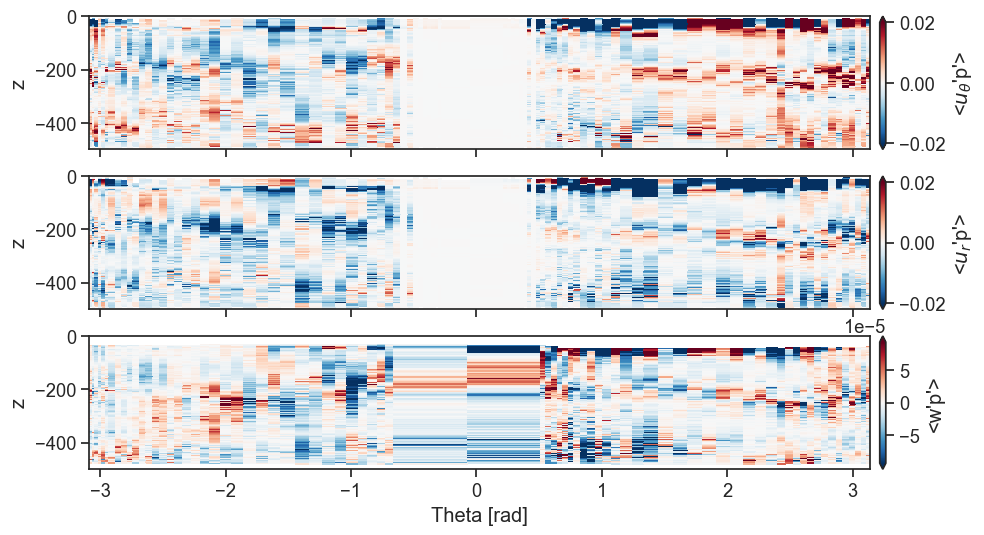

In [1700]:
fig, ax =plt.subplots(3,1, sharex=True)
raw.utheta_p.dropna('time',how='all').swap_dims({'time':'theta'}).sortby('theta').plot(
    robust=True, vmin=-0.02,vmax=0.02,cmap='RdBu_r',ax=ax[0], cbar_kwargs={'label':r"<$u_{\theta}$'p'>",'pad':0.01})
ax[0].set_xlabel(None)
raw.ur_p.dropna('time',how='all').swap_dims({'time':'theta'}).sortby('theta').plot(
    robust=True, vmin=-0.02,vmax=0.02,cmap='RdBu_r', ax=ax[1], cbar_kwargs={'label':r"<$u_{r}$'p'>",'pad':0.01} )
ax[1].set_xlabel(None)

raw.wp.dropna('time',how='all').swap_dims({'time':'theta'}).sortby('theta').plot(
    robust=True, ax=ax[2], cbar_kwargs={'label':r"<w'p'>",'pad':0.01} )
ax[2].set_xlabel('Theta [rad]')

ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[2].set_ylim(-500,0)

plt.savefig('../figures/polar_fluxes/polar_fluxes_vs_theta.pdf')

(-500.0, 0.0)

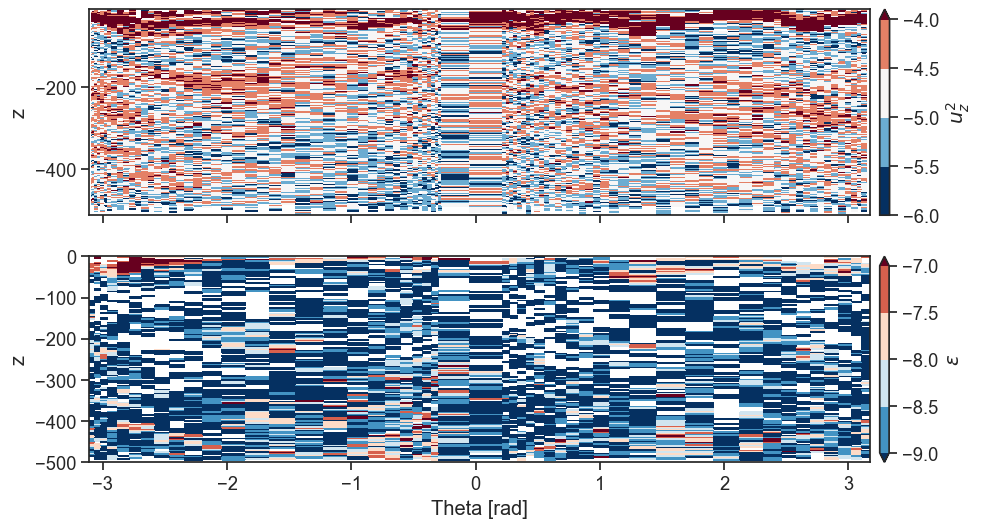

In [1701]:
fig, ax =plt.subplots(2,1, sharex=True)
(raw.S2.where(raw.S2 > 1e-6).swap_dims({'time':'theta'}).sortby('theta')
         .dropna('z',how='all').pipe(np.log10).plot(
             robust=True, ax=ax[0], cmap='RdBu_r',vmin=-6,vmax=-4,levels=5, cbar_kwargs={'label':r"$u_z^2$",'pad':0.01}))
ax[0].set_xlabel(None)
(raw.eps.where(raw.eps > 1e-10).swap_dims({'time':'theta'}).sortby('theta')
         .dropna('theta', how='all') #.dropna('z')
        .pipe(np.log10).plot(
            ax=ax[1], cmap='RdBu_r', vmin=-9,vmax=-7, levels=5, cbar_kwargs={'label':r"$\varepsilon$",'pad':0.01}))
ax[1].set_xlabel('Theta [rad]')
ax[1].set_ylim(-500,0)

In [1702]:
L=100000
f = gsw.f(40.7)
raw['banom'] = (raw.rho0 - rawall.rho0.mean('time')).sel(time=slice(*events[event]['times']))/f/L**2

Text(0.99, -0.2, '2016')

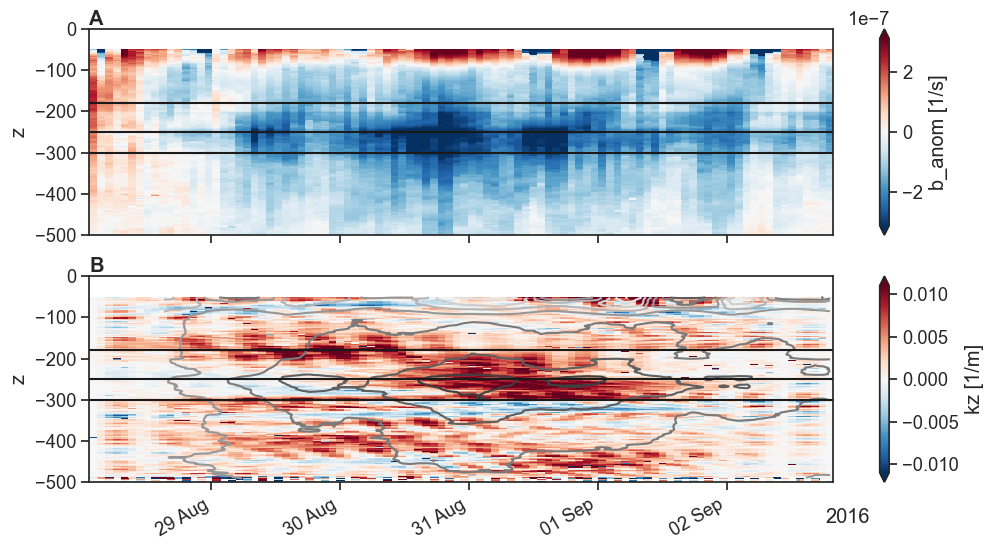

In [1703]:
fig, ax = plt.subplots(2,1,sharex=True)

raw.banom.dropna('time',how='all').where(raw.z < -50).plot(robust=True, cbar_kwargs={'label':'b_anom [1/s]'}, ax=ax[0], cmap='RdBu_r')
ax[0].set_ylim(-500,0)
ax[0].axhline(-180,color='k')
ax[0].axhline(-250,color='k')
ax[0].axhline(-300,color='k')

raw.hke_kz.dropna('time',how='all').where(raw.z < -50).plot(robust=True, cbar_kwargs={'label':'kz [1/m]'}, ax=ax[1])

raw.banom.dropna('time',how='all').where(raw.z < -50).rolling(time=10).mean().plot.contour(ax=ax[1],cmap='Greys_r',levels=10)
ax[1].set_ylim(-500,0)
ax[1].axhline(-180,color='k')
ax[1].axhline(-250,color='k')
ax[1].axhline(-300,color='k')

alphabet(ax)
for ax in ax:
    ax.set_xlabel(None)
    ax.xaxis.set_major_formatter(myFmt)
ax.annotate('2016',(0.99,-0.2),xycoords='axes fraction')

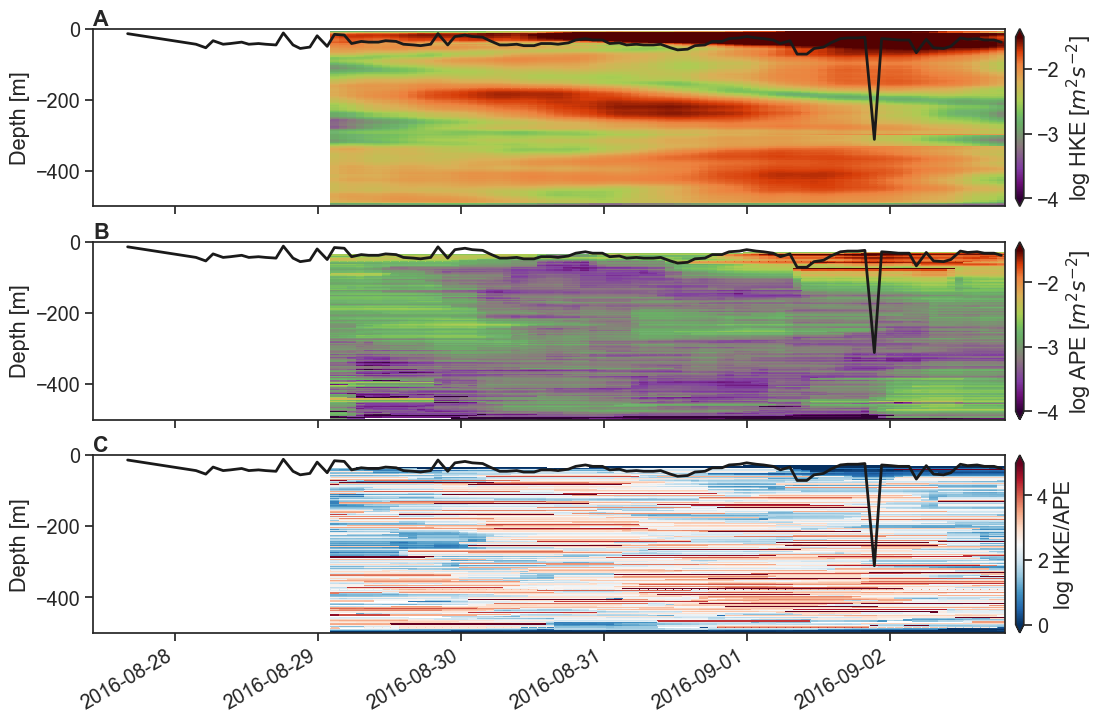

In [1423]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
fig, ax = plt.subplots(3,1, sharex=True, figsize=(14,8))

raw.hkeNI.fillna(0).rolling(time=18).mean().pipe(np.log10).plot(
    vmin=-4, vmax=-1.5, cmap=purp, ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'log HKE [$m^2 s^{-2}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


raw.eta_ape.fillna(0).rolling(time=18).mean().pipe(np.log10).plot(
    vmin=-4, vmax=-1.5, cmap=purp, ax=ax[1], rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE [$m^2 s^{-2}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

raw.hke_ape.fillna(0).rolling(time=18).mean().pipe(np.log10).plot(
    vmin=0, vmax=5, cmap='RdBu_r', ax=ax[2], rasterized=True,
                               cbar_kwargs={'pad':0.01,'label':'log HKE/APE'})
raw.mld.plot(color='k', lw=2, ax=ax[2])
ax[2].set_ylim(-500,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

alphabet(ax)

fig.savefig(f'../figures/events/A/hke_ape_{event}_{floatid}.pdf')

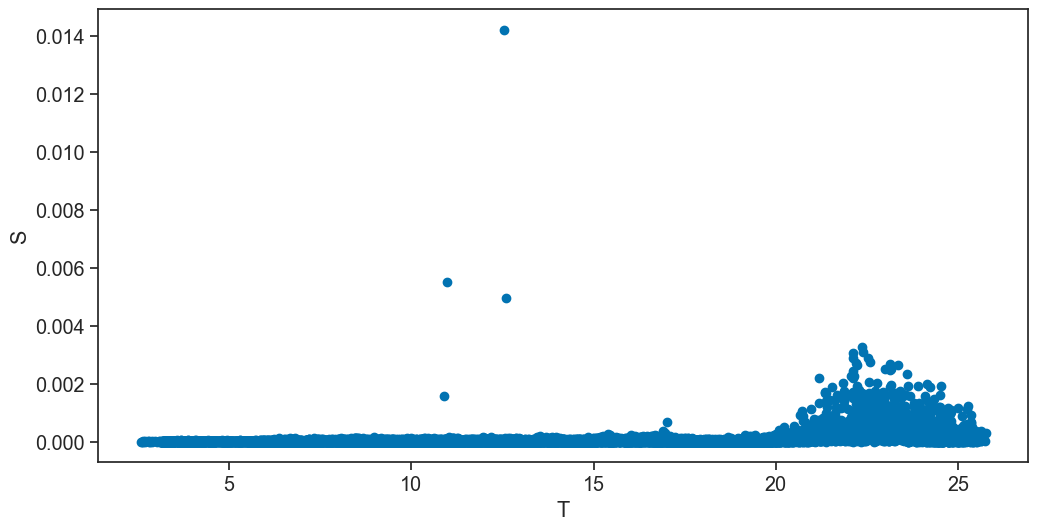

In [1424]:
raw.plot.scatter('T','S')

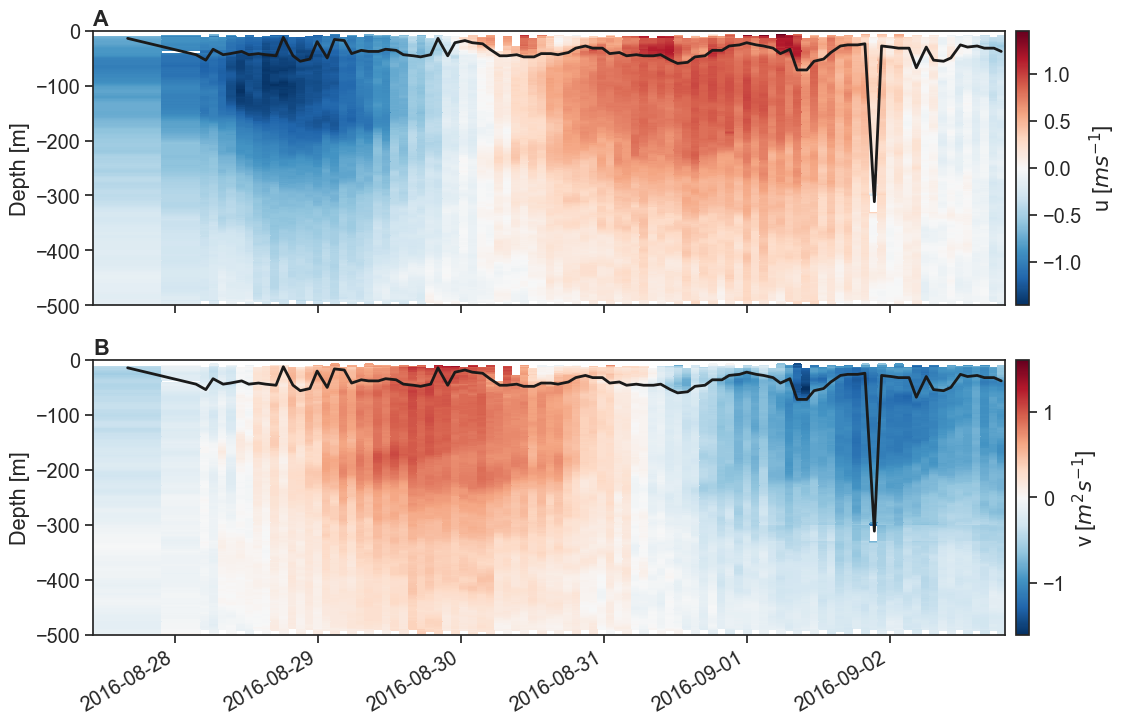

In [1425]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(2,1, sharex=True, figsize=(14,8))

(raw.u-raw.uNI).plot(cmap='RdBu_r', ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'u [$m s^{-1}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


(raw.v-raw.vNI).plot(cmap='RdBu_r', ax=ax[1], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'v [$m^2 s^{-1}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

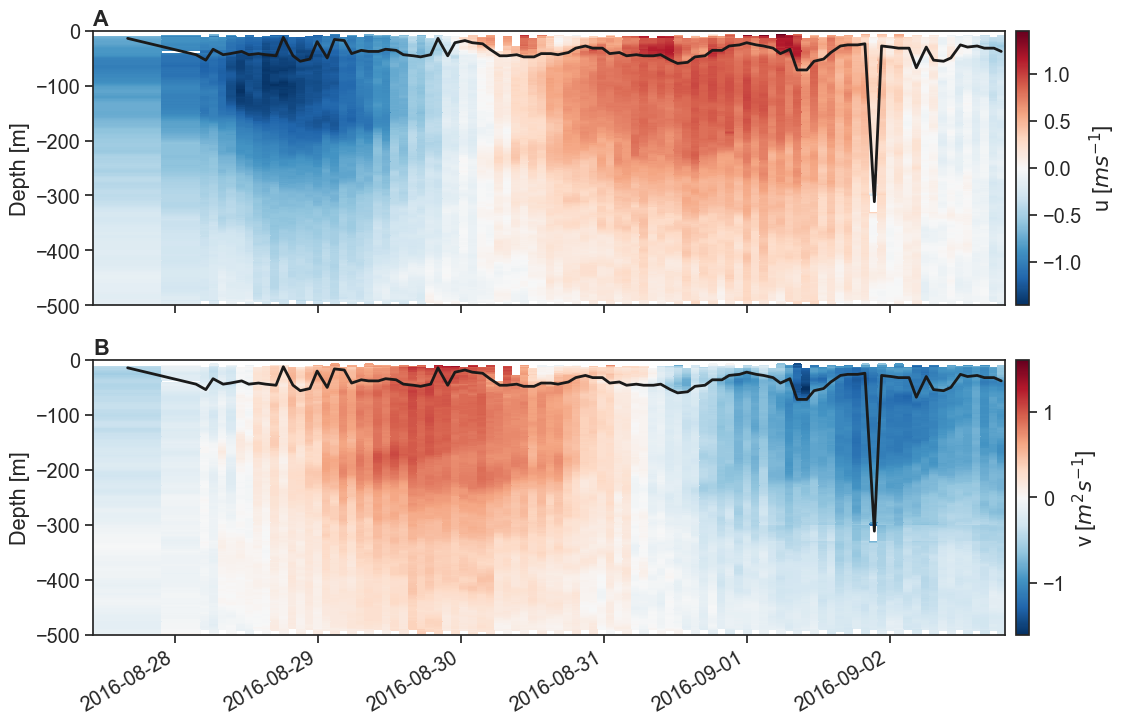

In [1426]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(2,1, sharex=True, figsize=(14,8))

(raw.u-raw.uNI).plot(cmap='RdBu_r', ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'u [$m s^{-1}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


(raw.v-raw.vNI).plot(cmap='RdBu_r', ax=ax[1], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'v [$m^2 s^{-1}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/subinerial_velocity_{event}_{floatid}_nihke.pdf')

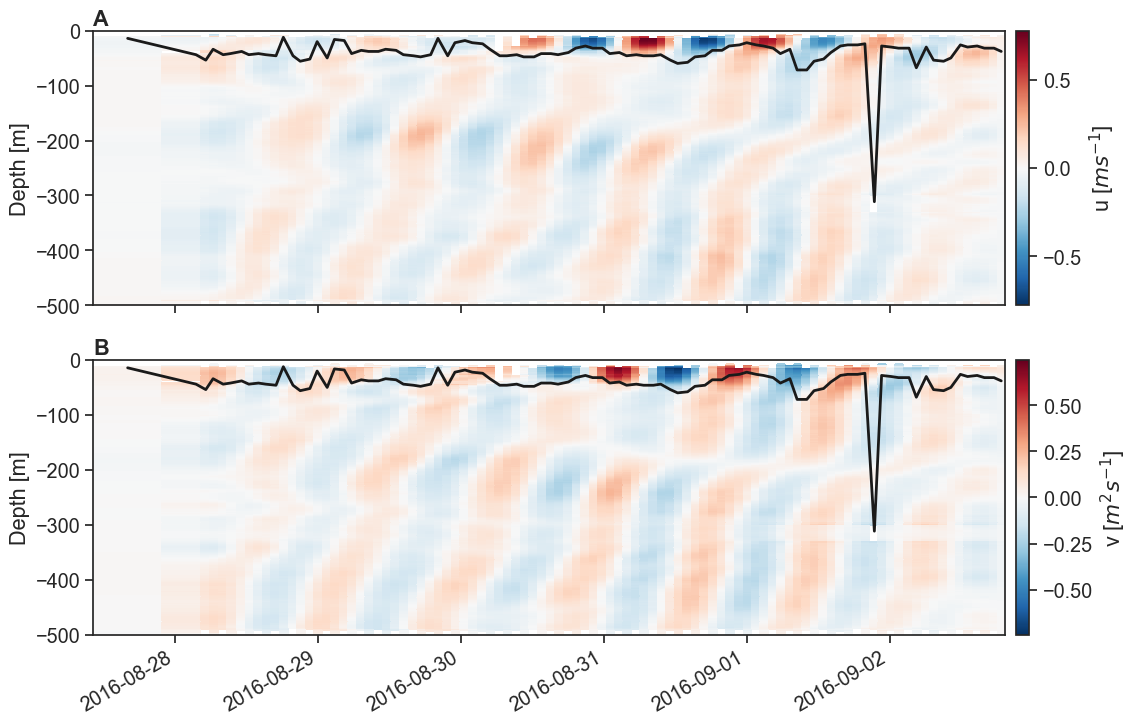

In [1427]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(2,1, sharex=True, figsize=(14,8))

raw.uNI.plot(cmap='RdBu_r', ax=ax[0], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'u [$m s^{-1}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')


raw.vNI.plot(cmap='RdBu_r', ax=ax[1], rasterized=True,
                             cbar_kwargs={'pad':0.01,'label':'v [$m^2 s^{-1}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/inerial_velocity_{event}_{floatid}_nihke.pdf')

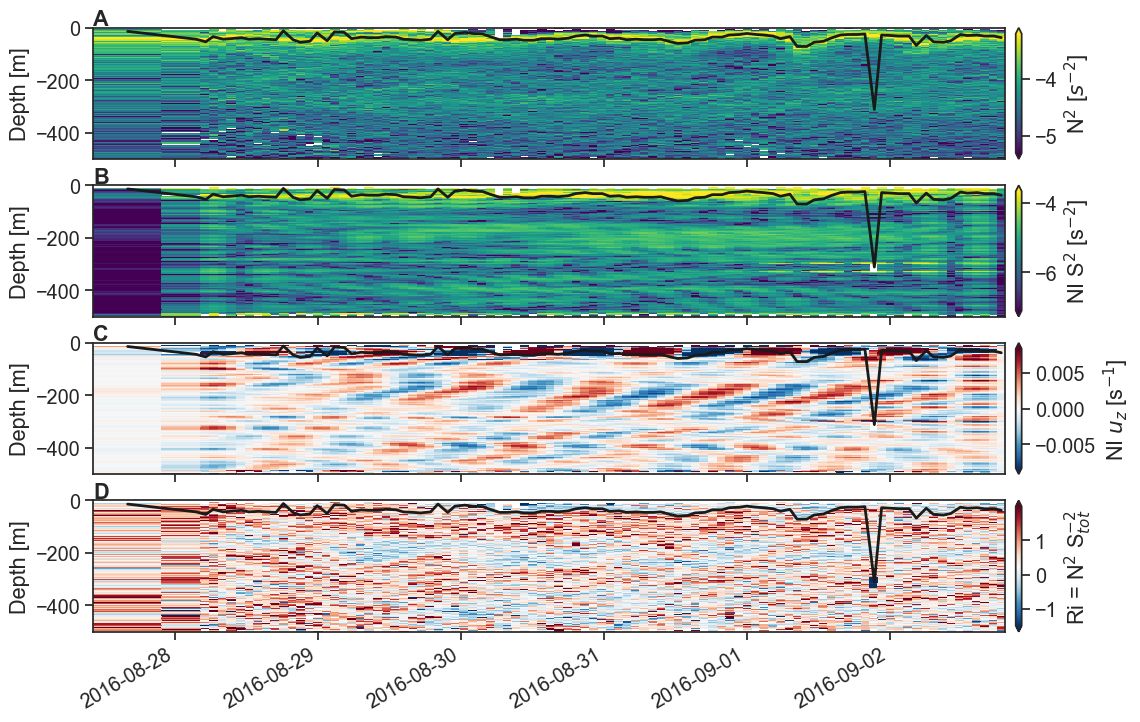

In [1428]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(4,1, sharex=True, figsize=(14,8))
raw.n2.pipe(np.log10).plot(ax=ax[0], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':'N$^2$ [$s^{-2}$]'})
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.SNI.pipe(np.log10).plot( ax=ax[1], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':'NI S$^2$ [s$^{-2}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

raw.dudzNI.plot( ax=ax[2], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':'NI $u_z$ [s$^{-1}$]'})
raw.mld.plot(color='k', lw=2,ax=ax[2])
ax[2].set_ylim(-500,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

(raw.n2/raw.S2).pipe(np.log10).plot(cmap='RdBu_r', ax=ax[3], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':'Ri = N$^2$ S$_{tot}^{-2}$'}, center=0.25)
raw.mld.plot(color='k', lw=2,ax=ax[3])
ax[3].set_ylim(-500,0)
ax[3].set_xlabel(None)
ax[3].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/n2andshear_{event}_{floatid}_nihke.pdf')

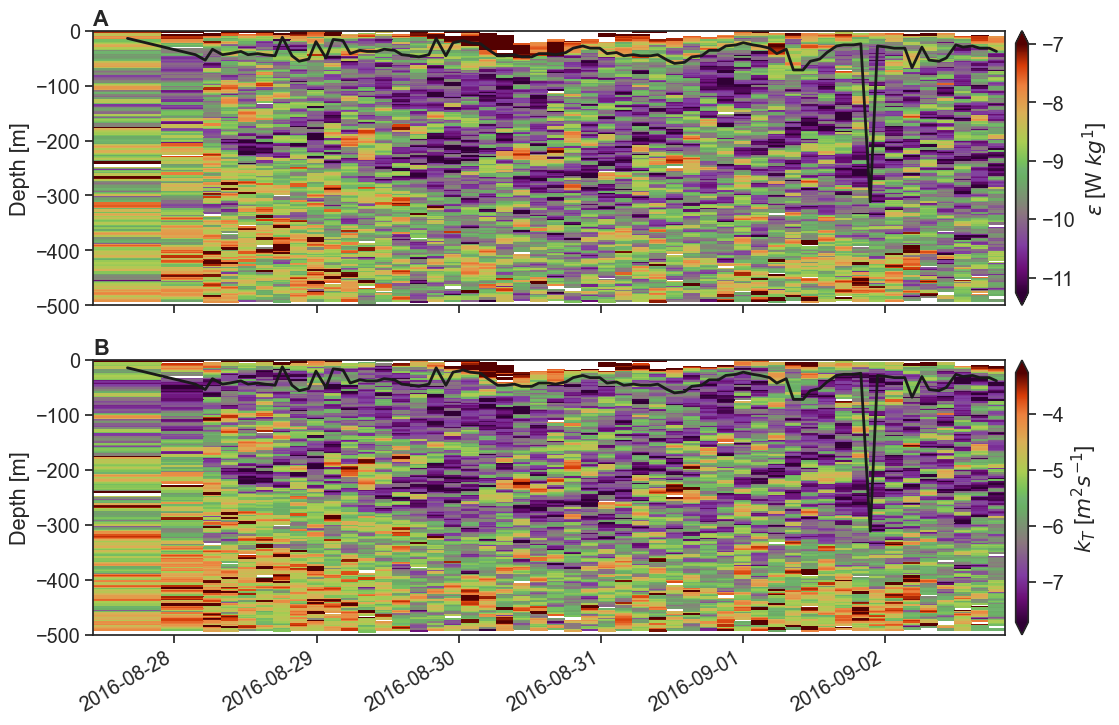

In [1429]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(2,1, sharex=True, figsize=(14,8))
raw.eps.dropna('time','all').pipe(np.log10).plot(ax=ax[0], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':r'$\varepsilon$ [W $kg^1$]'},cmap=purp)
raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.kT.dropna('time','all').pipe(np.log10).plot( ax=ax[1], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':'$k_T$ [$m^2 s^{-1}$]'},cmap=purp)
raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/epsilon_{event}_{floatid}_nihke.pdf')

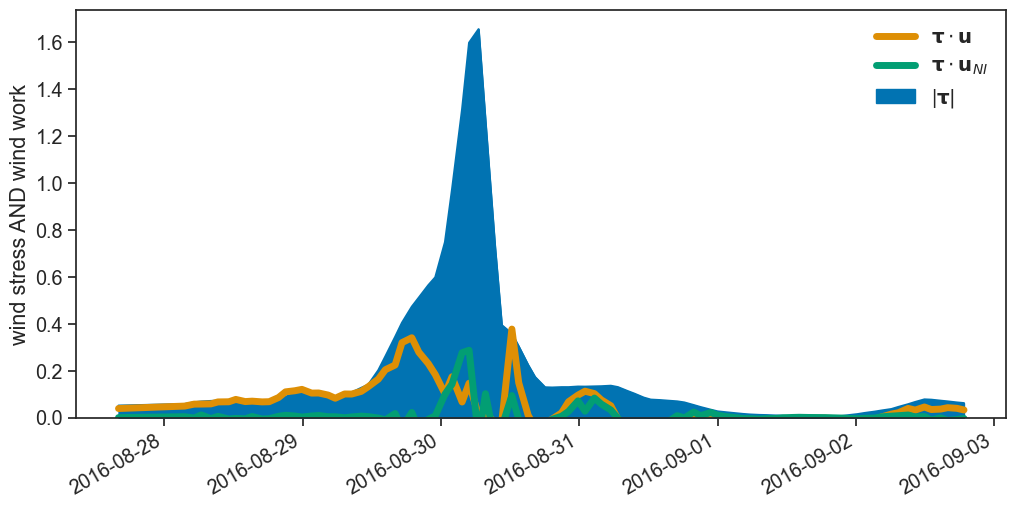

In [1430]:
raw.tau.to_series().plot.area(label=r'|$\mathbf{\tau}|$')
raw.taudotu.plot(lw=5,label=r'$\mathbf{\tau} \cdot \mathbf{u}$')
raw.taudotu_ni.plot(lw=5,label=r'$\mathbf{\tau} \cdot \mathbf{u}_{NI}$')

plt.legend()
plt.ylabel('wind stress AND wind work')
plt.xlabel(None)

plt.savefig(f'../figures/events/A/wind_{event}_{floatid}.pdf')

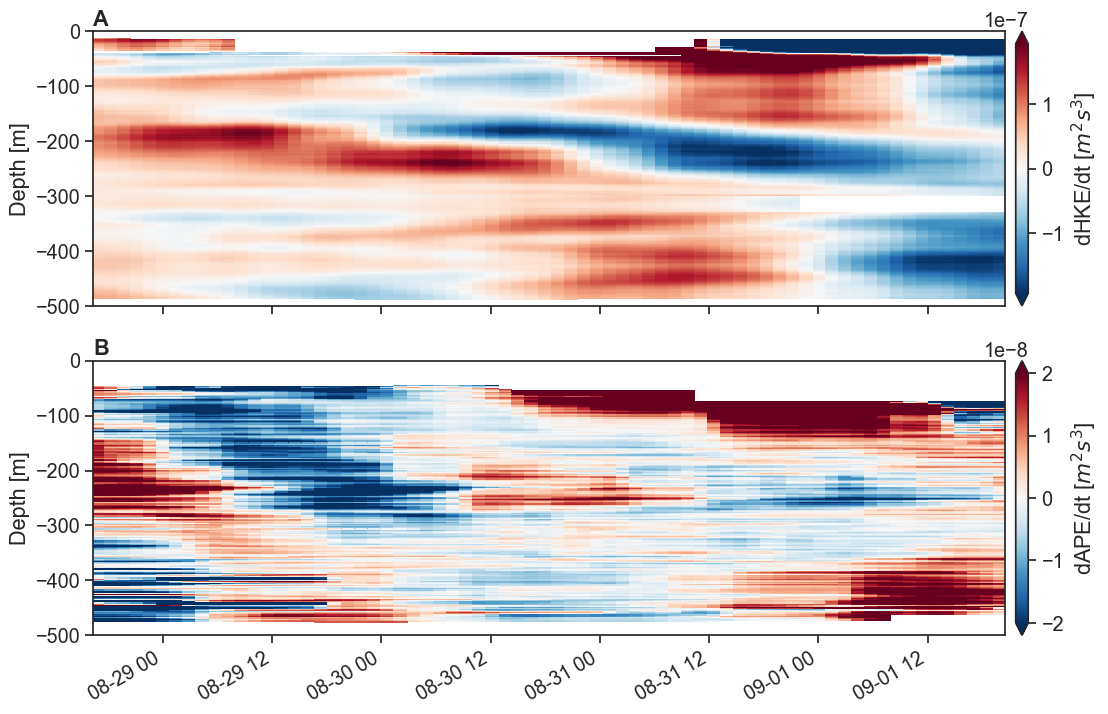

In [1431]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(2,1, sharex=True, figsize=(14,8))
raw.dhke.dropna('time','all').rolling(time=18, center=True).mean().dropna('z','all').plot(ax=ax[0], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':r'dHKE/dt [$m^2 s^3$]'},cmap='RdBu_r')
# raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.dape.rolling(time=18, center=True).mean().dropna('time','all').dropna('z','all').plot( ax=ax[1], rasterized=True,vmin=-2e-8,vmax=2e-8,
                             cbar_kwargs={'pad':0.01,'label':'dAPE/dt [$m^2 s^3$]'},cmap='RdBu_r')
# raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

# f.savefig(f'../figures/events/A/power_{event}_{floatid}.pdf')

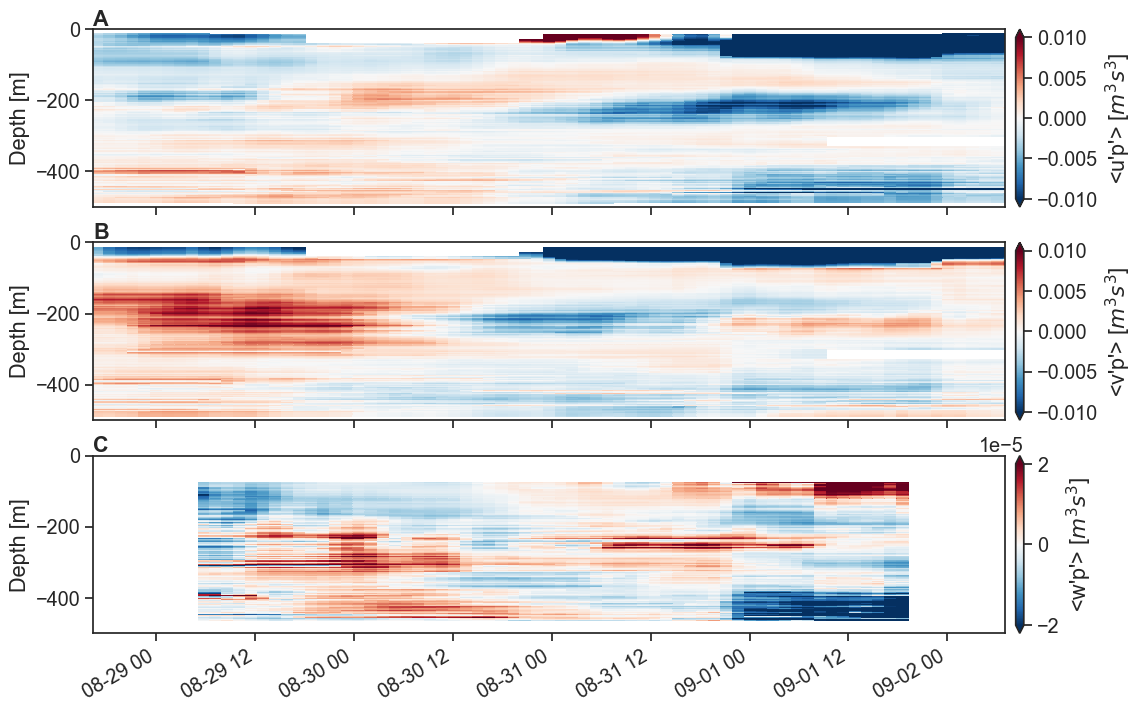

In [1432]:
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
f, ax = plt.subplots(3,1, sharex=True, figsize=(14,8))
raw.up.dropna('time','all').rolling(time=18, center=True).mean().plot(ax=ax[0], rasterized=True,vmin=-0.01, vmax=0.01,
                             cbar_kwargs={'pad':0.01,'label':r"<u'p'> [$m^3 s^3$]"},cmap='RdBu_r')
# raw.mld.plot(color='k', lw=2, ax=ax[0])
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.vp.dropna('time','all').rolling(time=18, center=True).mean().plot( ax=ax[1], rasterized=True,vmin=-0.01, vmax=0.01,
                             cbar_kwargs={'pad':0.01,'label':r"<v'p'> [$m^3 s^3$]"},cmap='RdBu_r')
# raw.mld.plot(color='k', lw=2,ax=ax[1])
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

raw.wp.dropna('time','all').dropna('z').rolling(time=18, center=True).mean().plot( ax=ax[2], rasterized=True,robust=True,
                             cbar_kwargs={'pad':0.01,'label':r"<w'p'> [$m^3 s^3$]"},cmap='RdBu_r')
# raw.mld.plot(color='k', lw=2,ax=ax[2])
ax[2].set_ylim(-500,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/efluxes_{event}_{floatid}.pdf')

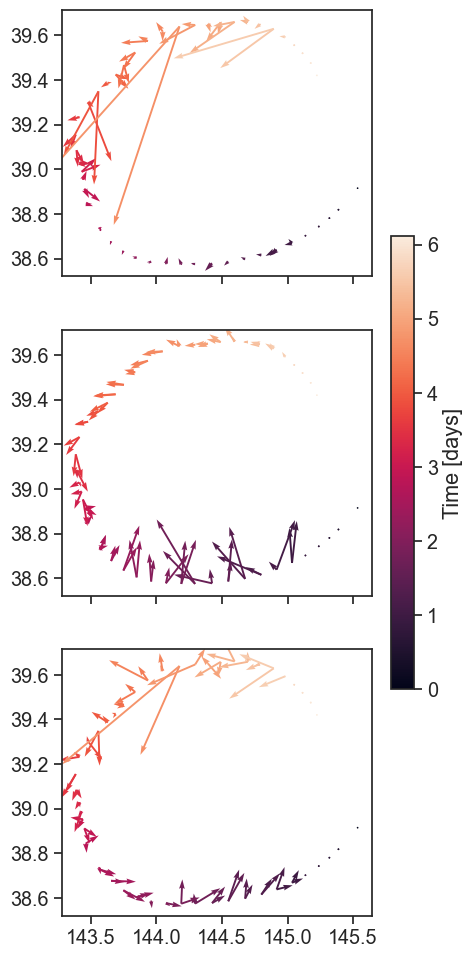

In [1433]:
sel1 = raw.where( (raw.z > -100) ).mean('z')
sel2 = raw.where( (raw.z < -100) & (raw.z > -300) ).mean('z')
sel3 = raw.where( (raw.z < -300) & (raw.z > -600) ).mean('z')

fig, ax = plt.subplots(3,1, figsize=(5,12), sharex=True)

h = ax[0].quiver(sel1.lon, sel1.lat, sel1.up, sel1.vp, sel1.dtime/86400)
h = ax[1].quiver(sel2.lon, sel2.lat, sel2.up, sel2.vp, sel1.dtime/86400)
h = ax[2].quiver(sel3.lon, sel3.lat, sel3.up, sel3.vp, sel1.dtime/86400)

# fig.colorbar(pcm, ax=axs[:, col], shrink=0.6)
plt.colorbar(h, ax=ax[:], shrink=0.5, label='Time [days]')
# plt.subplots_adjust()
# plt.tight_layout()
fig.savefig(f'../figures/events/A/efluxes_map_{event}_{floatid}.pdf')

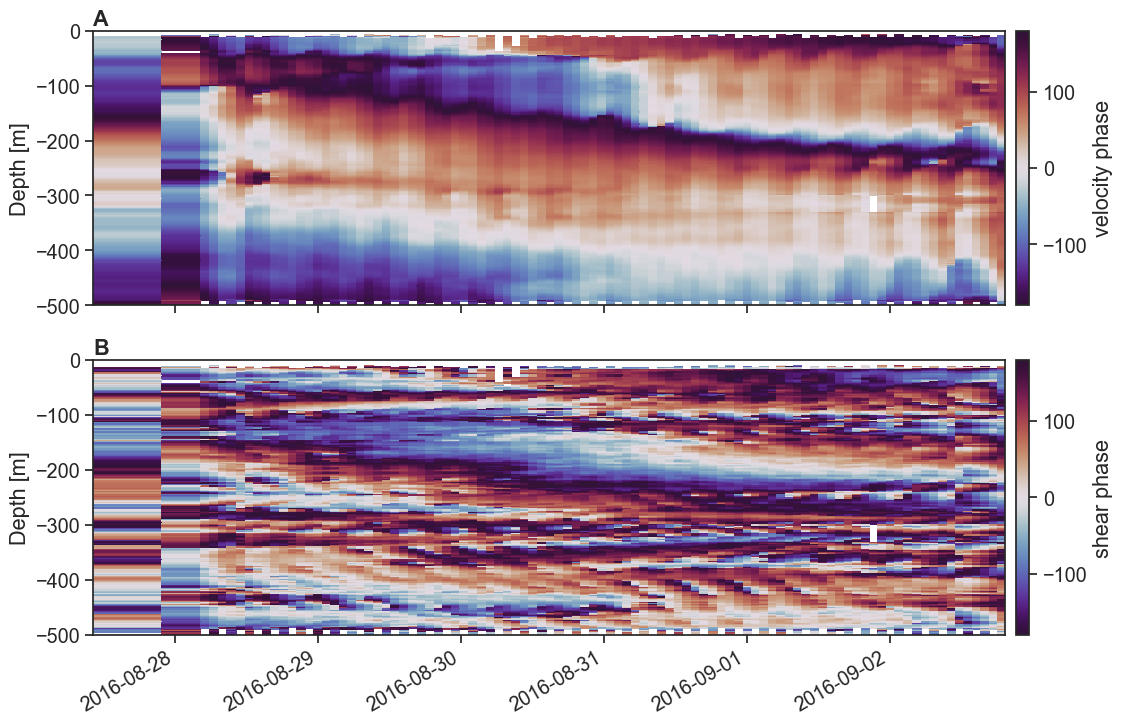

In [1434]:
f, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
raw.ang_br0.plot(ax=ax[0], cbar_kwargs={'pad':0.01,'label':r"velocity phase"},cmap='twilight_shifted',rasterized=True)
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.angS_br0.plot(ax=ax[1], cbar_kwargs={'pad':0.01,'label':r"shear phase"},cmap='twilight_shifted',rasterized=True)
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/backrotated_phase_{event}_{floatid}.pdf')

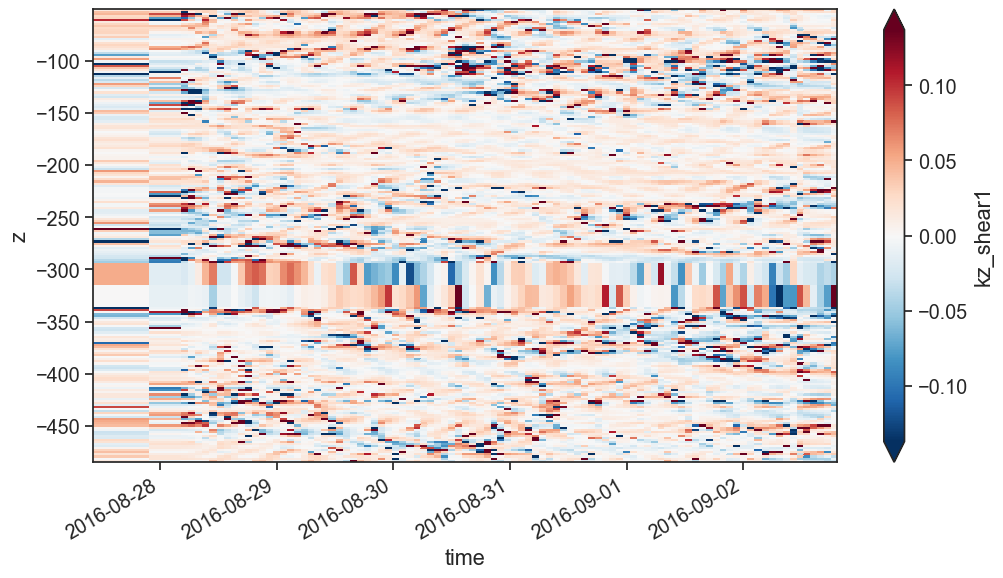

In [1435]:
raw.kz_shear1.dropna('z').plot(robust=True)

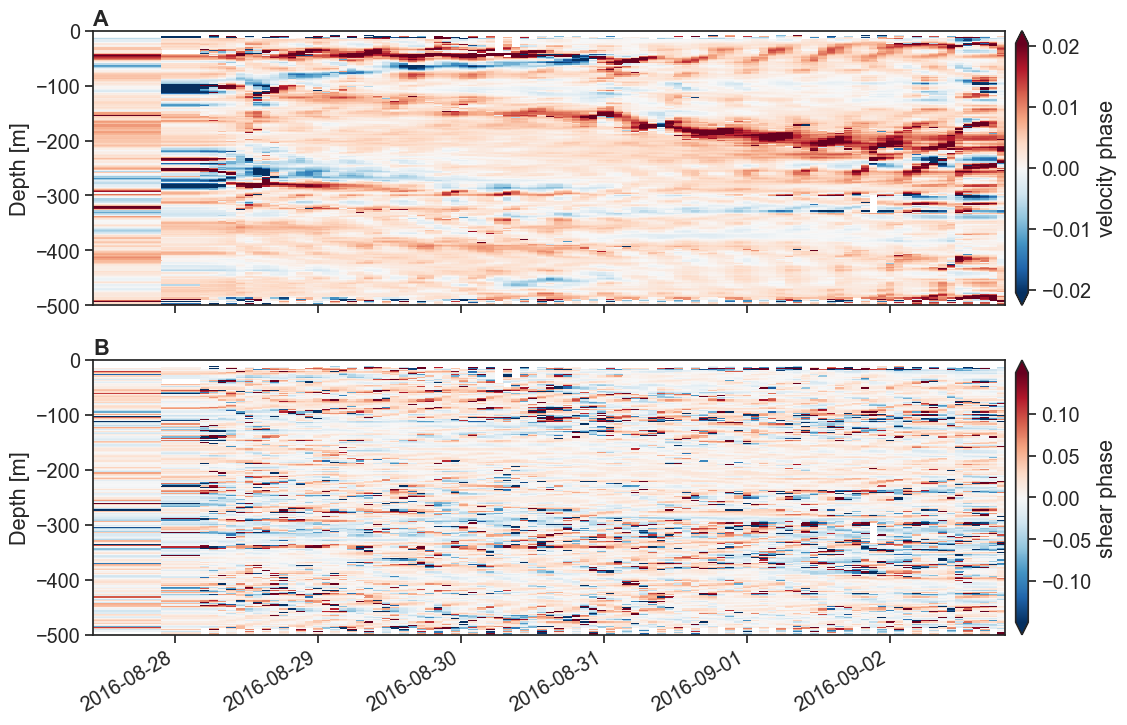

In [1436]:
f, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
raw.kz_vel1.plot(ax=ax[0], cbar_kwargs={'pad':0.01,'label':r"velocity phase"},cmap='RdBu_r',rasterized=True, robust=True)
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.kz_shear1.plot(ax=ax[1], cbar_kwargs={'pad':0.01,'label':r"shear phase"},cmap='RdBu_r',rasterized=True, robust=True)
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/backrotated_phase_{event}_{floatid}.pdf')

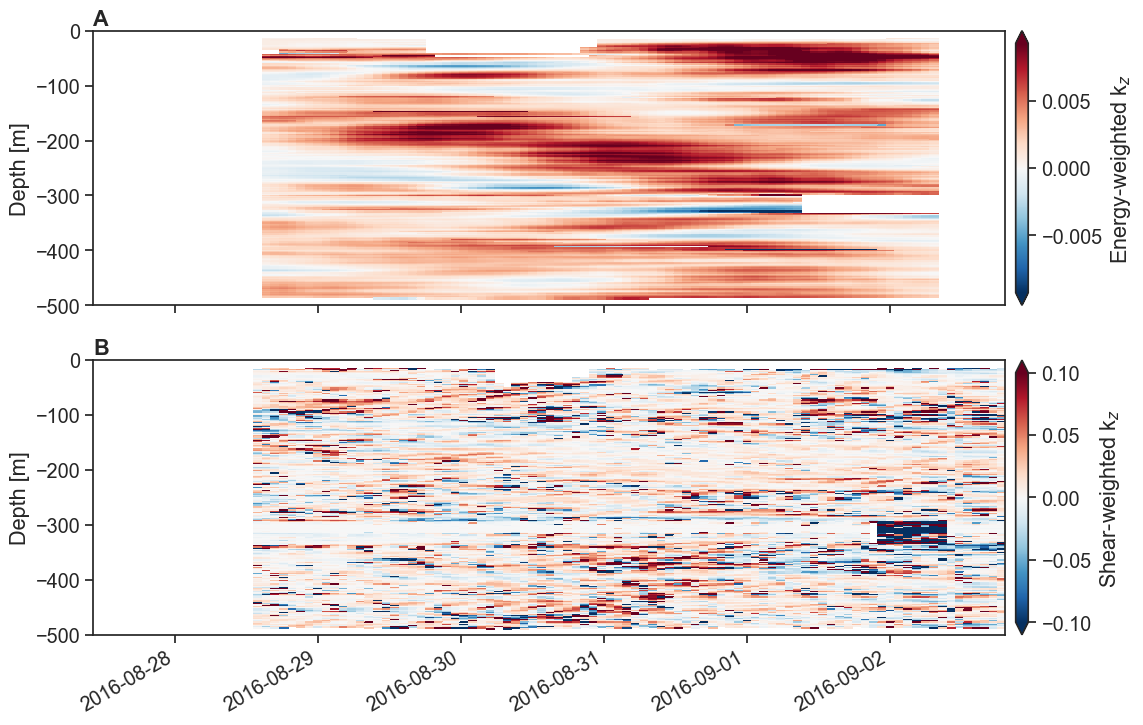

In [1437]:


f, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
raw.hke_kz.rolling(time=18,center=True).mean().plot(ax=ax[0], cbar_kwargs={'pad':0.01,'label':r"Energy-weighted k$_z$"},cmap='RdBu_r',rasterized=True, robust=True)
ax[0].set_ylim(-500,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Depth [m]')

raw.hke_shear_kz.plot(ax=ax[1], cbar_kwargs={'pad':0.01,'label':r"Shear-weighted k$_z$"},cmap='RdBu_r',rasterized=True, vmin=-0.1,vmax=0.1)
ax[1].set_ylim(-500,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel('Depth [m]')

alphabet(ax)

f.savefig(f'../figures/events/A/energy_weighted_kz_{event}_{floatid}.pdf')